<a href="https://colab.research.google.com/github/ShuqairABD/AutoDistill---YOLOv8m/blob/main/YOLOv8m_320_photos_50_%D1%8D%D0%BF%D0%BE%D1%85_%D0%BE%D0%B1%D1%83%D1%87%D0%B8%D1%82%D1%8C_%D0%BC%D0%BE%D0%B4%D0%B5%D0%BB%D1%8C_YOLOv8_%D0%B0%D0%B2%D1%82%D0%BE%D0%BC%D0%B0%D1%82%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%B8_%D1%81_%D0%BF%D0%BE%D0%BC%D0%BE%D1%89%D1%8C%D1%8E_Auto_distill.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Проект по распознаванию кузовных деталей на автомобилях.**


---





**Как автоматически обучить модель YOLOv8 с помощью Auto distill :**







**GPU**



In [ ]:
#!nvidia-smi для вывода информации о GPU.
!nvidia-smi

Sun Jan 21 14:48:45 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-SXM2-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0              25W / 300W |      0MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

##  Установите автоматическую дистилляцию Autodistill

Autodistill - это экосистема для использования больших, медленных базовых моделей для обучения небольших, более быстрых контролируемых моделей. Каждая базовая модель, а также целевая модель имеют свой собственный отдельный репозиторий и пакет pip.

In [ ]:
# Установка библиотеки
!pip install -q autodistill==0.1.24
!pip install -q autodistill-grounded-sam
!pip install -q autodistill_yolov8
!pip install -q roboflow
!pip install -q supervision==0.9.0

In [ ]:
# !pip install -q autodistill==0.1.21
# !pip install -q autodistill-grounded-sam
# !pip install -q autodistill_yolov8
# !pip install -q roboflow
# !pip install -q supervision==0.9.0

In [ ]:
# !pip install -q autodistill==0.1.21
# !pip install -q autodistill-grounded-sam==0.1.1
# !pip install -q autodistill_yolov8
# !pip install -q roboflow==1.1.15
# !pip install -q supervision==0.9.0


In [ ]:
# !pip install -q \
# autodistill \
# autodistill-grounded-sam \
# autodistill-yolov8 \
# roboflow \
# supervision==0.9.0

In [ ]:
# Отображение информации о библиотеке (optional)
# !pip show autodistill
# !pip show autodistill-grounded-sam
# !pip show autodistill-yolov8
# !pip show roboflow
# !pip show supervision

Name: autodistill
Version: 0.1.1
Summary: Distill large foundational models into smaller, domain-specific models for deployment
Home-page: https://github.com/autodistill/autodistill
Author: Roboflow
Author-email: jacob@roboflow.com
License: 
Location: /usr/local/lib/python3.10/dist-packages
Requires: opencv-python, Pillow, PyYAML, supervision, tqdm
Required-by: autodistill-grounded-sam, autodistill-yolov8
Name: autodistill-grounded-sam
Version: 0.1.1
Summary: Automatically distill large foundational models into smaller, in-domain models for deployment
Home-page: https://github.com/autodistill/autodistill
Author: Roboflow
Author-email: jacob@roboflow.com
License: 
Location: /usr/local/lib/python3.10/dist-packages
Requires: autodistill, numpy, opencv-python, rf-groundingdino, rf-segment-anything, supervision, torch
Required-by: 
Name: autodistill-yolov8
Version: 0.1.3
Summary: Automatically distill large foundational models into smaller, in-domain models for deployment
Home-page: https:/

##  Подготовка набора данных изображений

**NOTE:** Чтобы использовать автоматическую сортировку, все, что вам нужно, - это папка с изображениями, которые вы хотите автоматически аннотировать и использовать для обучения целевой модели.

Чтобы нам было проще управлять наборами данных, изображениями и моделями, мы создаем константу `HOME`.

In [ ]:
import os # Импорт библиотеки os для работы с операционной системой
HOME = os.getcwd() # Получение текущего рабочего каталога (домашней директории) и сохранение в переменную HOME
print(HOME) # Вывод на экран текущей директории

/content


In [ ]:
# Создание новой директории "images" в текущей HOME директории
!mkdir {HOME}/images

Как только вы загрузите свой набор данных, переместите все изображения из набора "train" в вашем загруженном наборе данных в каталог "изображения/", который мы создали ранее.

In [ ]:
IMAGE_DIR_PATH = f"{HOME}/images" # Путь к директории изображений, созданной ранее
# FRAME_STRIDE = 10

Теперь мы готовы начать использовать Auto distill!

### Образец отображаемого изображения



In [ ]:
import supervision as sv # Импорт библиотеки supervision

# Получение списка путей к файлам изображений с расширениями "png", "jpg", "jpeg" в директории IMAGE_DIR_PATH
image_paths = sv.list_files_with_extensions(
    directory=IMAGE_DIR_PATH,
    extensions=["png", "jpg", "jpg"])

print('image count:', len(image_paths)) # Вывод количества найденных файлов изображений

image count: 322


In [ ]:
IMAGE_DIR_PATH = f"{HOME}/images" # Обновление переменной IMAGE_DIR_PATH с путем к директории изображений
SAMPLE_SIZE = 16 # Задание размера выборки изображений
SAMPLE_GRID_SIZE = (4, 4) # Задание размера сетки для отображения выборки (4 строки x 4 столбца)
SAMPLE_PLOT_SIZE = (16, 16) # Задание размера общего графика, на котором отображается выборка (16 x 16 дюймов)

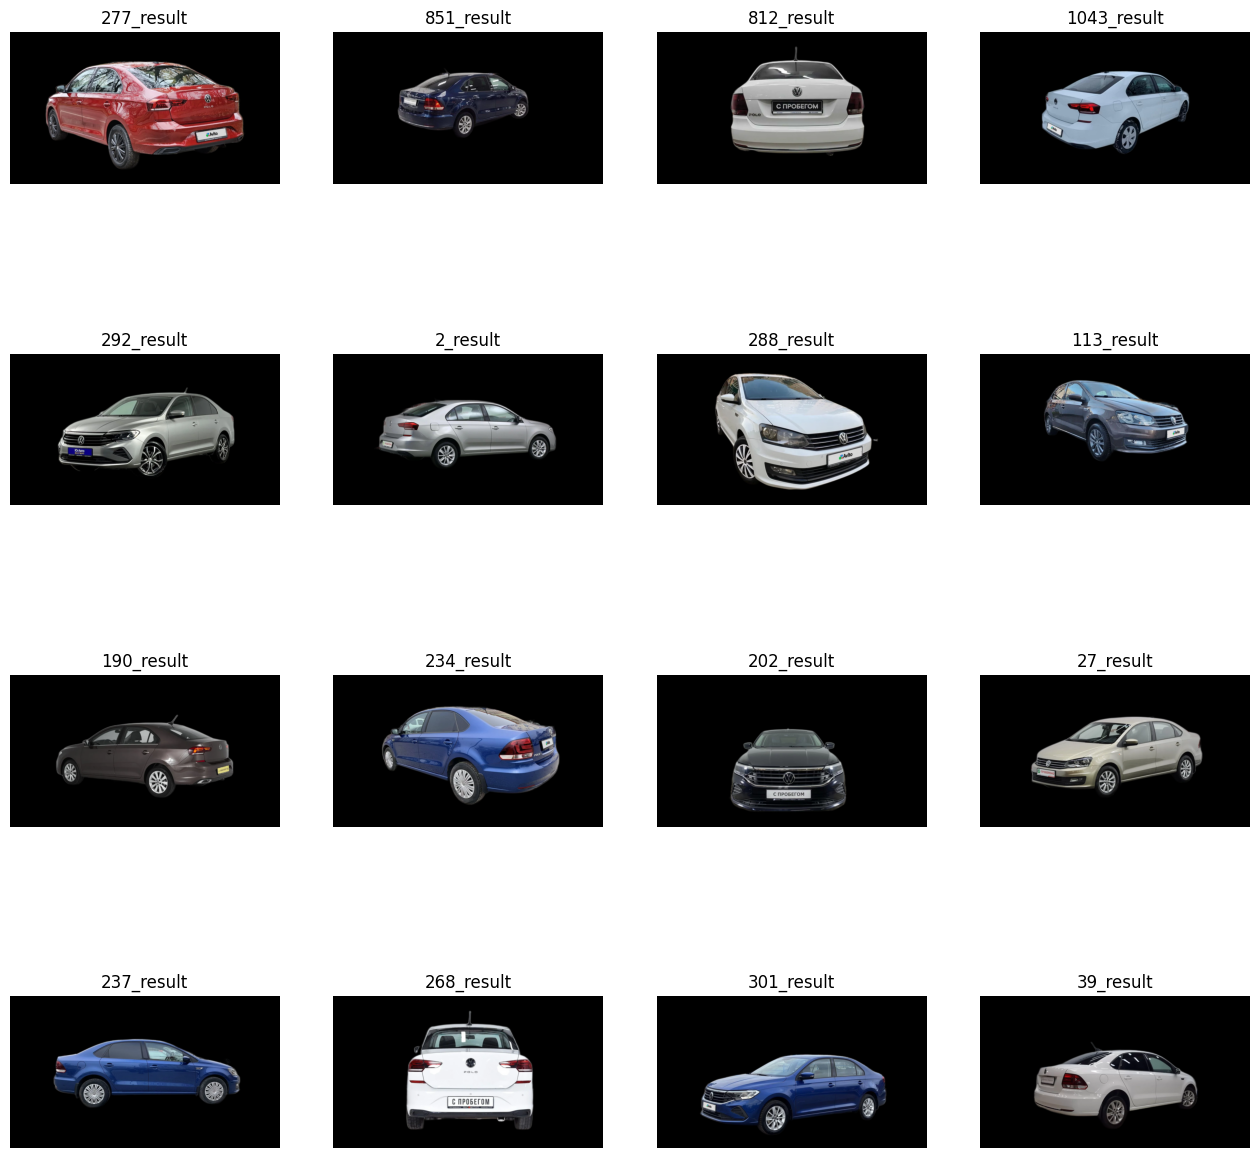

In [ ]:
import cv2 # Импорт библиотеки cv2 (OpenCV) для работы с изображениями
import supervision as sv

# Создание списка заголовков из имен файлов изображений (без расширений) из выборки
titles = [
    image_path.stem
    for image_path
    in image_paths[:SAMPLE_SIZE]]

# Загрузка изображений из выборки в список images с использованием OpenCV
images = [
    cv2.imread(str(image_path))
    for image_path
    in image_paths[:SAMPLE_SIZE]]

# Использование функции sv.plot_images_grid для отображения выборки изображений в виде сетки
sv.plot_images_grid(images=images, titles=titles, grid_size=SAMPLE_GRID_SIZE, size=SAMPLE_PLOT_SIZE)

## Набор данных автоматической маркировки



**Ontology** - Онтология определяет, как запрашивается ваша базовая модель, что будет описывать ваш набор данных и что будет предсказывать ваша целевая модель. Простая онтология - это онтология заголовков, которая запрашивает базовую модель с текстовыми подписями и сопоставляет их с именами классов. Другие онтологии могут, например, использовать вектор клипа или примеры изображений вместо текстовой подписи.

In [ ]:
# from autodistill.detection import CaptionOntology

# ontology=CaptionOntology({
#     "Rear bumper": "back bumper",
#     "Rear pillar with rear fender": "back pillar with back fender",
#     "Rear window": "back side window",
#     "Front fascia": "front bumper",
#     "Front quarter panel": "front fender",
#     "Front door handles": "door handles front",
#     "Rear door handles": "door handles back",
#     "Bonnet": "hood",
#     "Splash guard": "mudguard",
#     "Radiator grille": "Grille",
#     "Canopy": "roof",
#     "Front car windshield": "Windshield",
#     "Running boards": "side steps",
#     "Tyre": "tire",
#     "Side mirrors": "rear view mirrors",
#     "Rear door": "back door",
#     "Rear lights ": " back lights",
#     "Fog lamp ": " fog light",
#     "Driver's side door ": " front door",
#     "Driver's side windows ": " front side window",
#     "Headlight ": " front light",
#     "Alloy wheels ": " car rims",
#     "A-pillars ": " front pillars",
#     "Front turn signal": "Indicator light front",
#     "Rear turn signal": "Indicator light back",
#     "Tailpipe": "Exhaust pipe",
#     "Rear wing": "Spoiler",
#     "Fender flares": "Plastic wheel arch trim",
#     "Car Aerial": "Antenna"

# })

In [ ]:
from autodistill.detection import CaptionOntology # Импорт класса CaptionOntology из модуля autodistill.detection


# Создание объекта CaptionOntology с заданным словарем для сопоставления классов
ontology=CaptionOntology({
    "back bumper": "Rear bumper",
    "back pillar with back fender": "Rear pillar with rear fender",
    "back side window": "Rear window",
    "front bumper": "Front fascia",
    "front fender": "Front quarter panel",
    "door handles front": "Front door handles",
    "door handles back": "Rear door handles",
    "hood": "Bonnet",
    "mudguard": "Splash guard",
    "Grille": "Radiator grille",
    "roof": "Canopy",
    "Windshield": "Front car windshield",
    "side steps": "Running boards",
    "tire": "Tyre",
    "rear view mirrors": "Side mirrors",
    "back door": "Rear door",
    "back lights": "Rear lights",
    "fog light": "Fog lamp",
    "front door": "Driver's side door",
    "front side window": "Driver's side windows",
    "front light": "Headlight",
    "car rims": "Alloy wheels",
    "front pillars": "A-pillars",
    "Indicator light front": "Front turn signal",
    "Indicator light back": "Rear turn signal",
    "Exhaust pipe": "Tailpipe",
    "Spoiler": "Rear wing",
    "Plastic wheel arch trim": "Fender flares",
    "Antenna": "Car Aerial"

})

In [ ]:
# from autodistill.detection import CaptionOntology

# ontology=CaptionOntology({
#     "back bumper": "back bumper",
#     "back pillar with back fender": "back pillar with back fender",
#     "back glass": "back side window",
#     "front bumper": "front bumper",
#     "front fender": "front fender",
#     "door handles front": "door handles front",
#     "door handles back": "door handles back",
#     "hood": "hood",
#     "mudguard": "mudguard",
#     "radiator": "radiator",
#     "roof": "roof",
#     "shield": "shield",
#     "side steps": "side steps",
#     "tire": "tire",
#     "rear view mirrors": "rear view mirrors",
#     "back door": "back door",
#     "back lights ": " back lights",
#     "fog light ": " fog light",
#     "front door ": " front door",
#     "front side window ": " front side window",
#     "front light ": " front light",
#     "car rims ": " car rims",
#     "front pillars ": " front pillars"

# })

### Инициировать базовую модель и автоматическую маркировку

**Base Model** - Базовая модель - это большая базовая модель, которая знает много о многом. Базовые модели часто являются мультимодальными и могут выполнять множество задач. Они большие, медленные и дорогие. Примерами базовых моделей являются Grounded SAM и предстоящий мультимодальный вариант GPT-4. Мы используем базовую модель (вместе с немаркированными входными данными и онтологией) для создания набора данных.

In [ ]:
# Установка переменной DATASET_DIR_PATH с путем к директории датасета
DATASET_DIR_PATH = f"{HOME}/dataset"

In [ ]:
# Импорт класса GroundedSAM из модуля autodistill_grounded_sam для авторазметки!
from autodistill_grounded_sam import GroundedSAM

# Создание объекта GroundedSAM с использованием ранее определенной онтологии
base_model = GroundedSAM(ontology=ontology)

# Разметка датасета с использованием созданного объекта
# Вводные данные - изображения из IMAGE_DIR_PATH с расширением .png
# Результат сохраняется в output_folder (DATASET_DIR_PATH)
dataset = base_model.label(
    input_folder=IMAGE_DIR_PATH,
    extension=".png",
    output_folder=DATASET_DIR_PATH)

trying to load grounding dino directly
downloading dino model weights


torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)


final text_encoder_type: bert-base-uncased



The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Labeling /content/images/277_result.png:   0%|          | 0/322 [00:00<?, ?it/s]The `device` argument is deprecated and will be removed in v5 of Transformers.
torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
None of the inputs have requires_grad=True. Gradients will be None
The `device` argument is deprecated and will be removed in v5 of Transformers.
torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the t

Labeled dataset created - ready for distillation.


### Отобразить образец набора данных



In [ ]:
ANNOTATIONS_DIRECTORY_PATH = f"{HOME}/dataset/train/labels"  # Путь к директории с разметкой (аннотациями) тренировочного датасета
IMAGES_DIRECTORY_PATH = f"{HOME}/dataset/train/images"  # Путь к директории с изображениями тренировочного датасета
DATA_YAML_PATH = f"{HOME}/dataset/data.yaml"   # Путь к файлу YAML, описывающему данные датасета

In [ ]:
import supervision as sv


# Создание объекта DetectionDataset из данных в формате YOLO
# с указанными путями к изображениям, разметке и файлу YAML с данными
dataset = sv.DetectionDataset.from_yolo(
    images_directory_path=IMAGES_DIRECTORY_PATH,
    annotations_directory_path=ANNOTATIONS_DIRECTORY_PATH,
    data_yaml_path=DATA_YAML_PATH)

len(dataset)  # Вывод длины датасета (количество объектов в датасете)

257

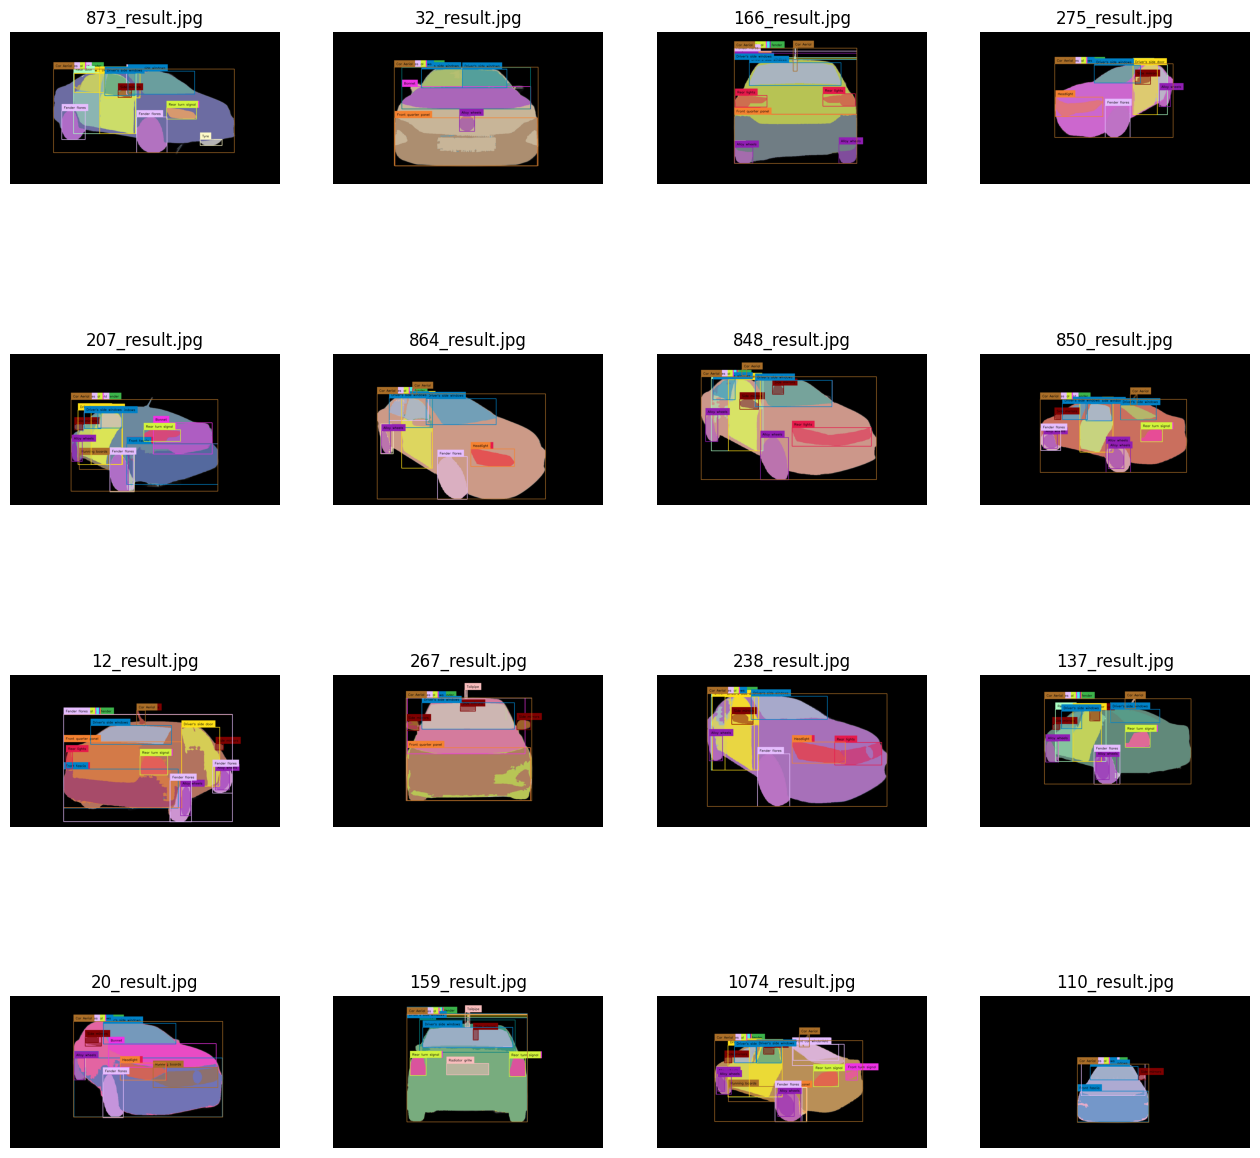

In [ ]:
import supervision as sv

# Создание списка имен изображений для использования в выборке
image_names = list(dataset.images.keys())[:SAMPLE_SIZE]

# Создание объектов для аннотации маск и прямоугольников(bounding box)
mask_annotator = sv.MaskAnnotator()
box_annotator = sv.BoxAnnotator()

# Список для хранения аннотированных изображений
images = []

# Цикл по именам изображений в выборке
for image_name in image_names:
    image = dataset.images[image_name]    # Получение изображения и соответствующих аннотаций из датасета
    annotations = dataset.annotations[image_name]

    # Получение меток классов на основе идентификаторов классов в аннотациях
    labels = [
        dataset.classes[class_id]
        for class_id
        in annotations.class_id]
    annotates_image = mask_annotator.annotate(  # Аннотирование изображения масками
        scene=image.copy(),
        detections=annotations)
    annotates_image = box_annotator.annotate(  # Аннотирование изображения прямоугольниками (bounding box)
        scene=annotates_image,
        detections=annotations,
        labels=labels)
    images.append(annotates_image)      # Добавление аннотированного изображения в список


# Отображение аннотированных изображений в виде сетки
sv.plot_images_grid(
    images=images,
    titles=image_names,
    grid_size=SAMPLE_GRID_SIZE,
    size=SAMPLE_PLOT_SIZE)

## Train target model - YOLOv8

**Target Model** - Целевая модель - это контролируемая модель, которая использует набор данных и выдает дистиллированную модель, готовую к развертыванию. Целевые модели обычно небольшие, быстрые и точно настроенные для очень хорошего выполнения конкретной задачи.

In [ ]:
%cd {HOME}  # Перемещение в текущую HOME директорию

from autodistill_yolov8 import YOLOv8  # Импорт модели YOLOv8 из библиотеки autodistill_yolov8 (для обучениея модели)
#("yolov8n.pt")
#("YOLOv8x.pt")
#("yolov8x-seg.pt")
target_model = YOLOv8("yolov8m.pt")  # Создание экземпляра YOLOv8 с указанием пути к предварительно обученному весу ("yolov8m.pt")
target_model.train(DATA_YAML_PATH, epochs=50)  # Обучение модели YOLOv8 на датасете с указанным файлом YAML

New https://pypi.org/project/ultralytics/8.1.3 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.81 🚀 Python-3.10.12 torch-2.1.0+cu121 CPU
yolo/engine/trainer: task=detect, mode=train, model=yolov8m.pt, data=/content/dataset/data.yaml, epochs=50, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=cpu, workers=8, project=None, name=None, exist_ok=False, pretrained=False, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, image_weights=False, rect=False, cos_lr=False, close_mosaic=0, resume=False, amp=True, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, line_thickness=3, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, f

/content


  8                  -1  2   3985920  ultralytics.nn.modules.C2f                   [576, 576, 2, True]           
  9                  -1  1    831168  ultralytics.nn.modules.SPPF                  [576, 576, 5]                 
 10                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
 11             [-1, 6]  1         0  ultralytics.nn.modules.Concat                [1]                           
 12                  -1  2   1993728  ultralytics.nn.modules.C2f                   [960, 384, 2]                 
 13                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
 14             [-1, 4]  1         0  ultralytics.nn.modules.Concat                [1]                           
 15                  -1  2    517632  ultralytics.nn.modules.C2f                   [576, 192, 2]                 
 16                  -1  1    332160  ultralytics.nn.modules.Conv                  [192,

#  Оценить целевую модель

**NOTE:** Как и в случае с обычным обучением YOLOv8, теперь мы можем взглянуть на артефакты, хранящиеся в каталоге "runs".

/content


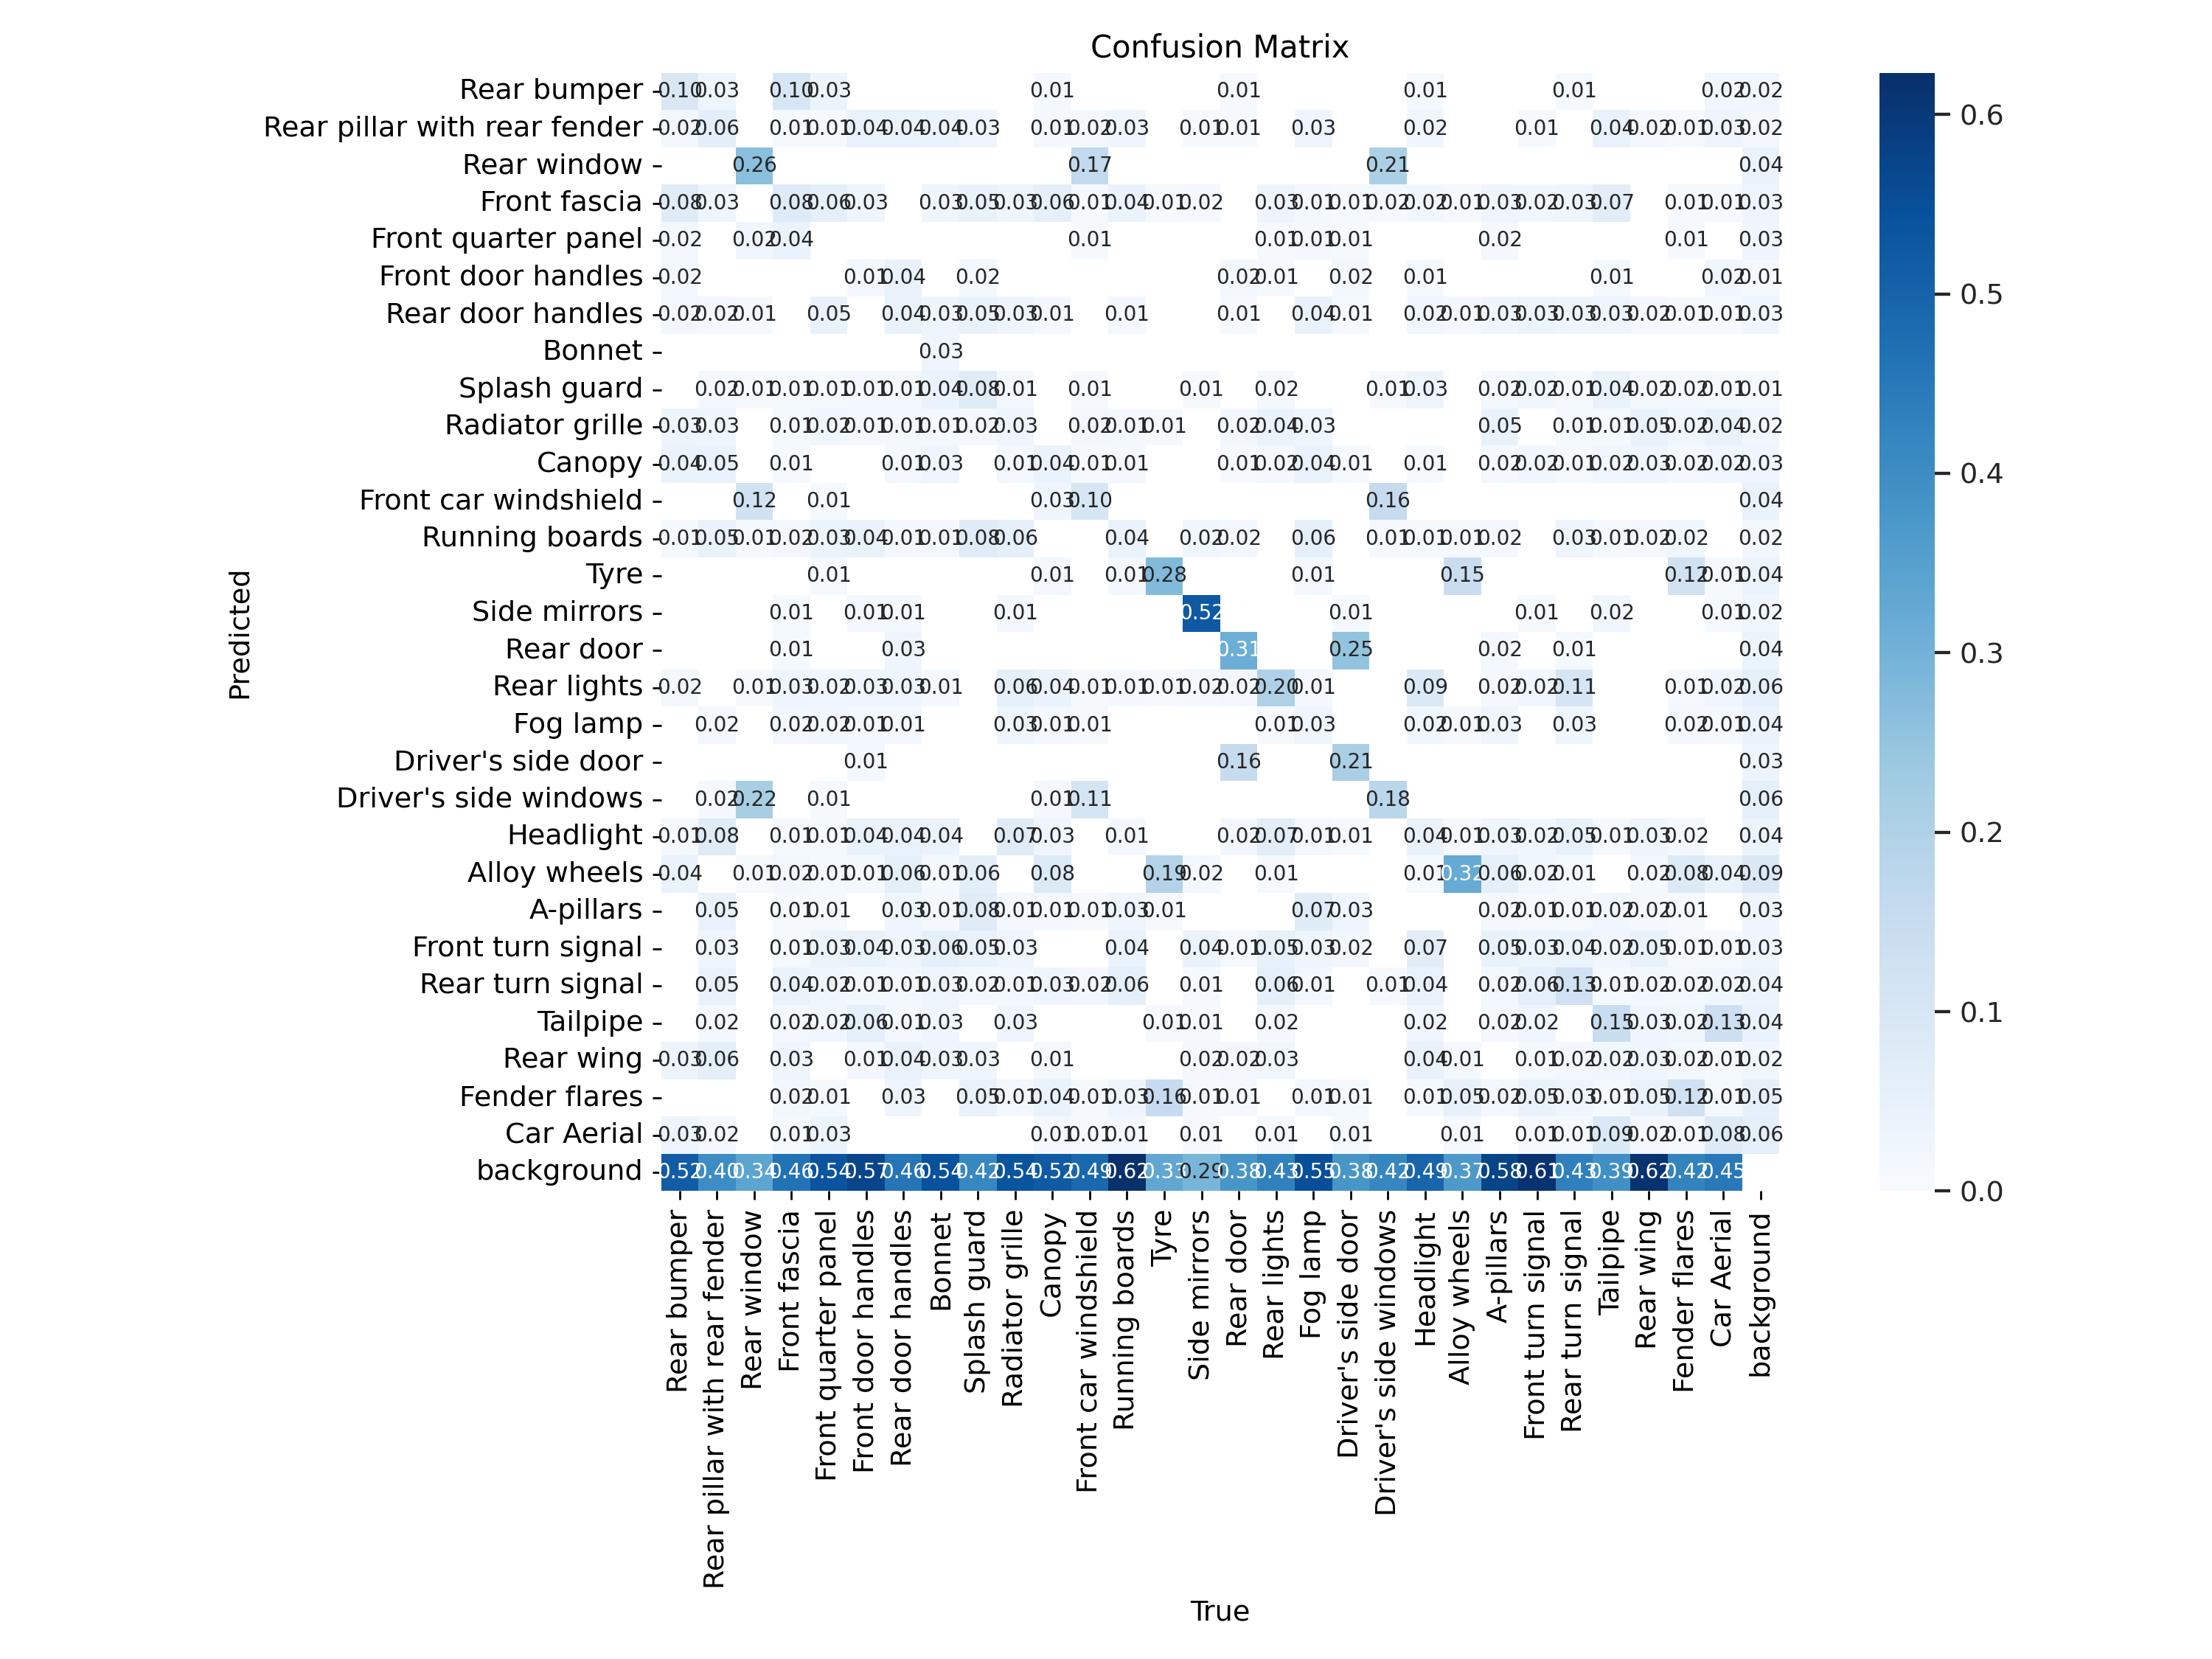

In [ ]:
# Переход в HOME директорию
%cd {HOME}

# Импорт модуля Image из библиотеки IPython для отображения изображения в ячейке кода
from IPython.display import Image

# Отображение изображения (confusion matrix) после обучения
Image(filename=f'{HOME}/runs/detect/train2/confusion_matrix.png', width=800)

/content


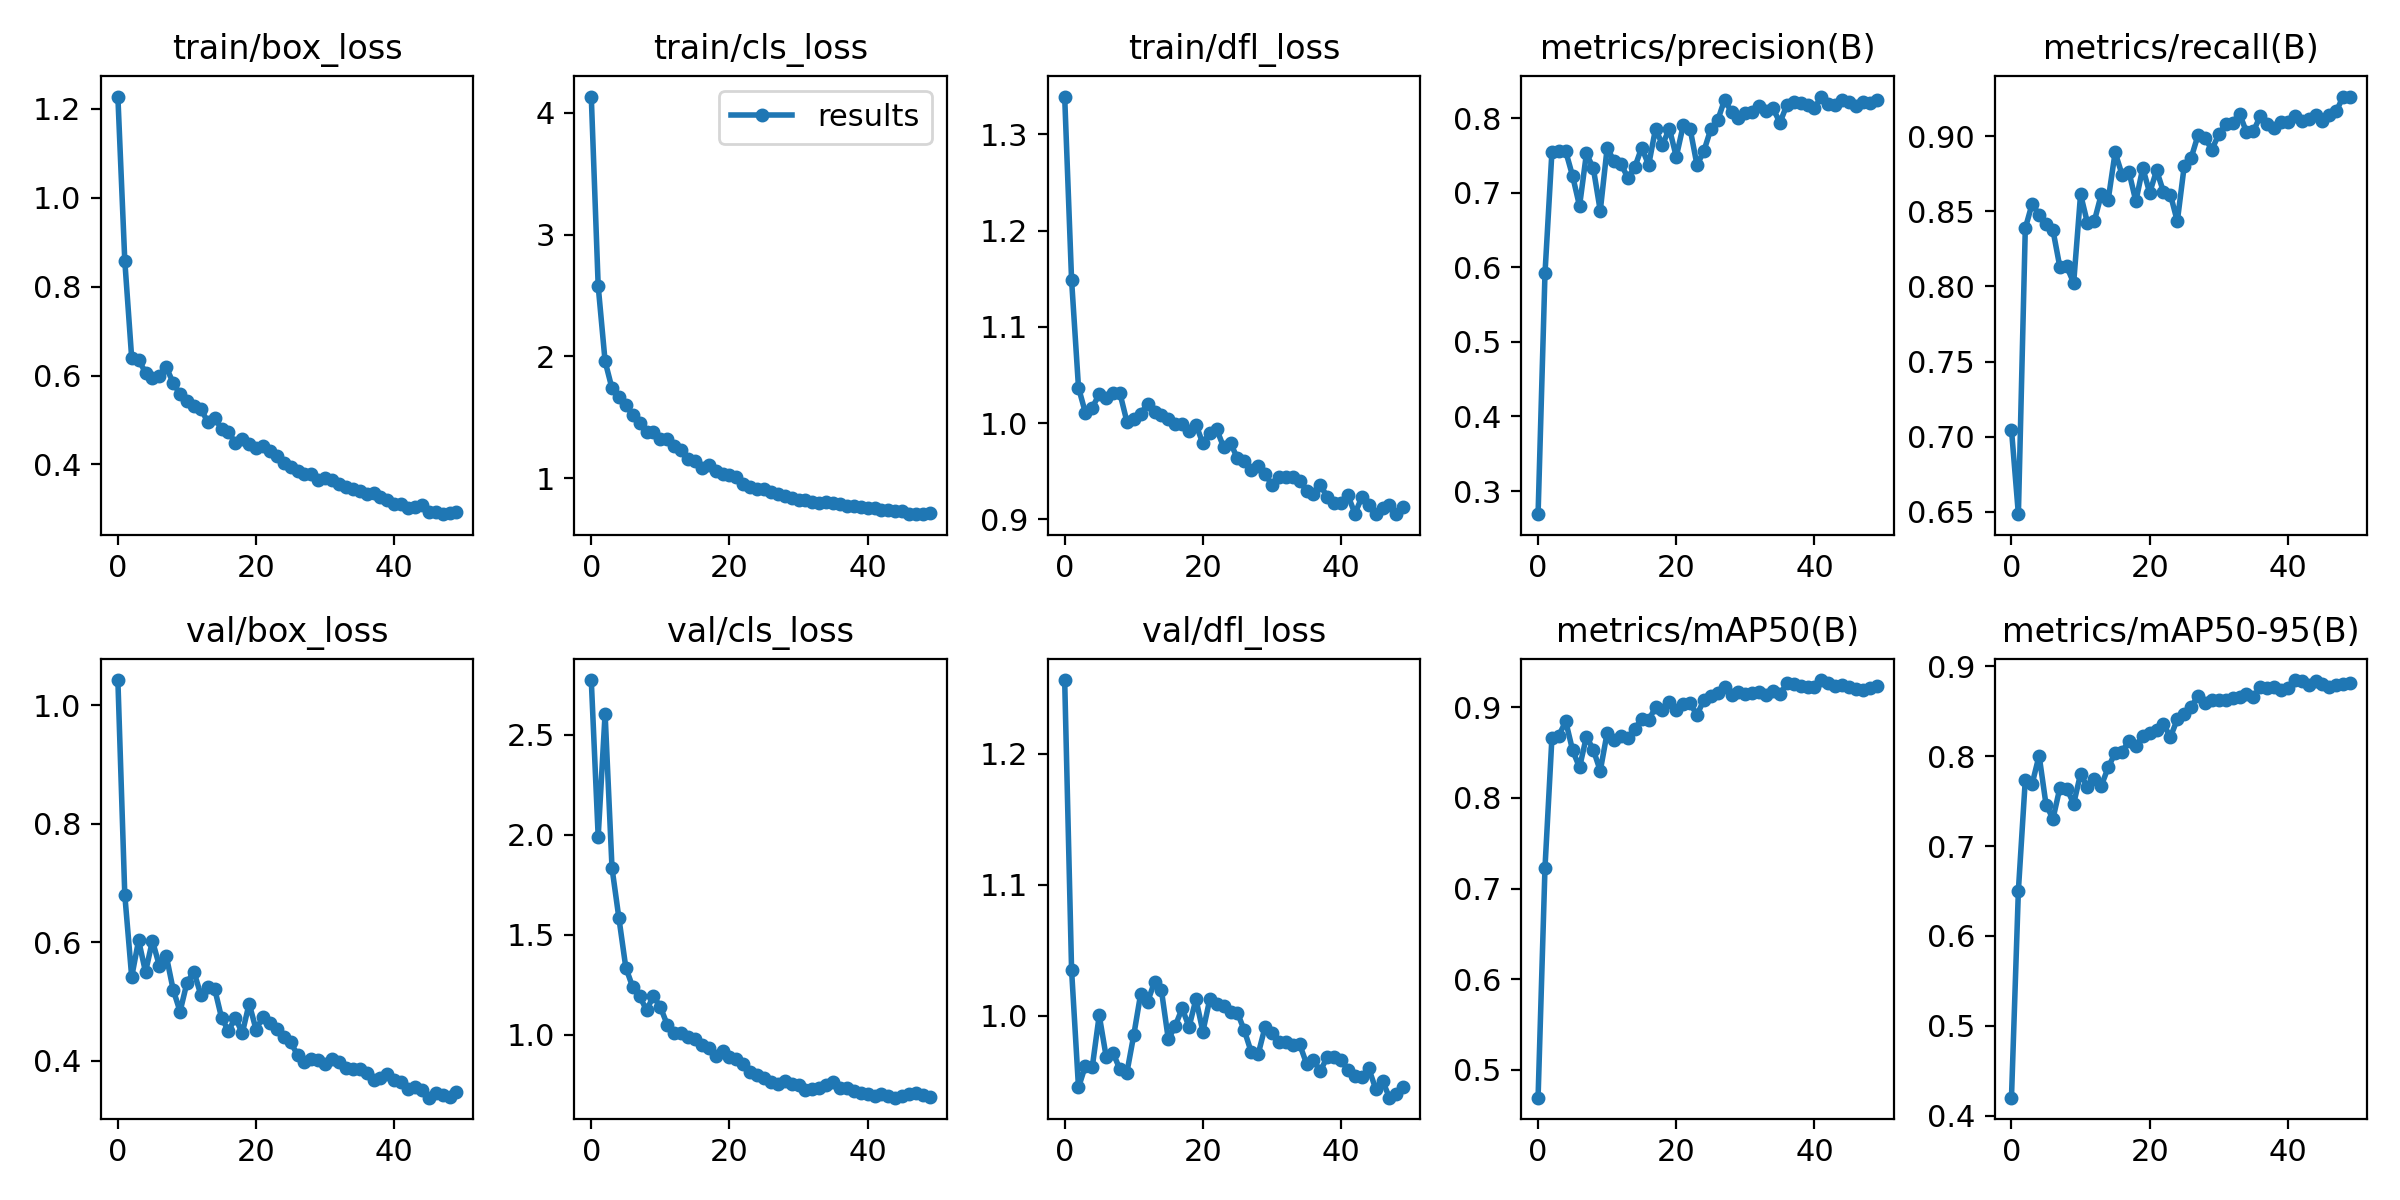

In [ ]:
%cd {HOME}

from IPython.display import Image

# Отображение изображения с результатами детекции (results.png) после обучения
Image(filename=f'{HOME}/runs/detect/train2/results.png', width=800)

/content


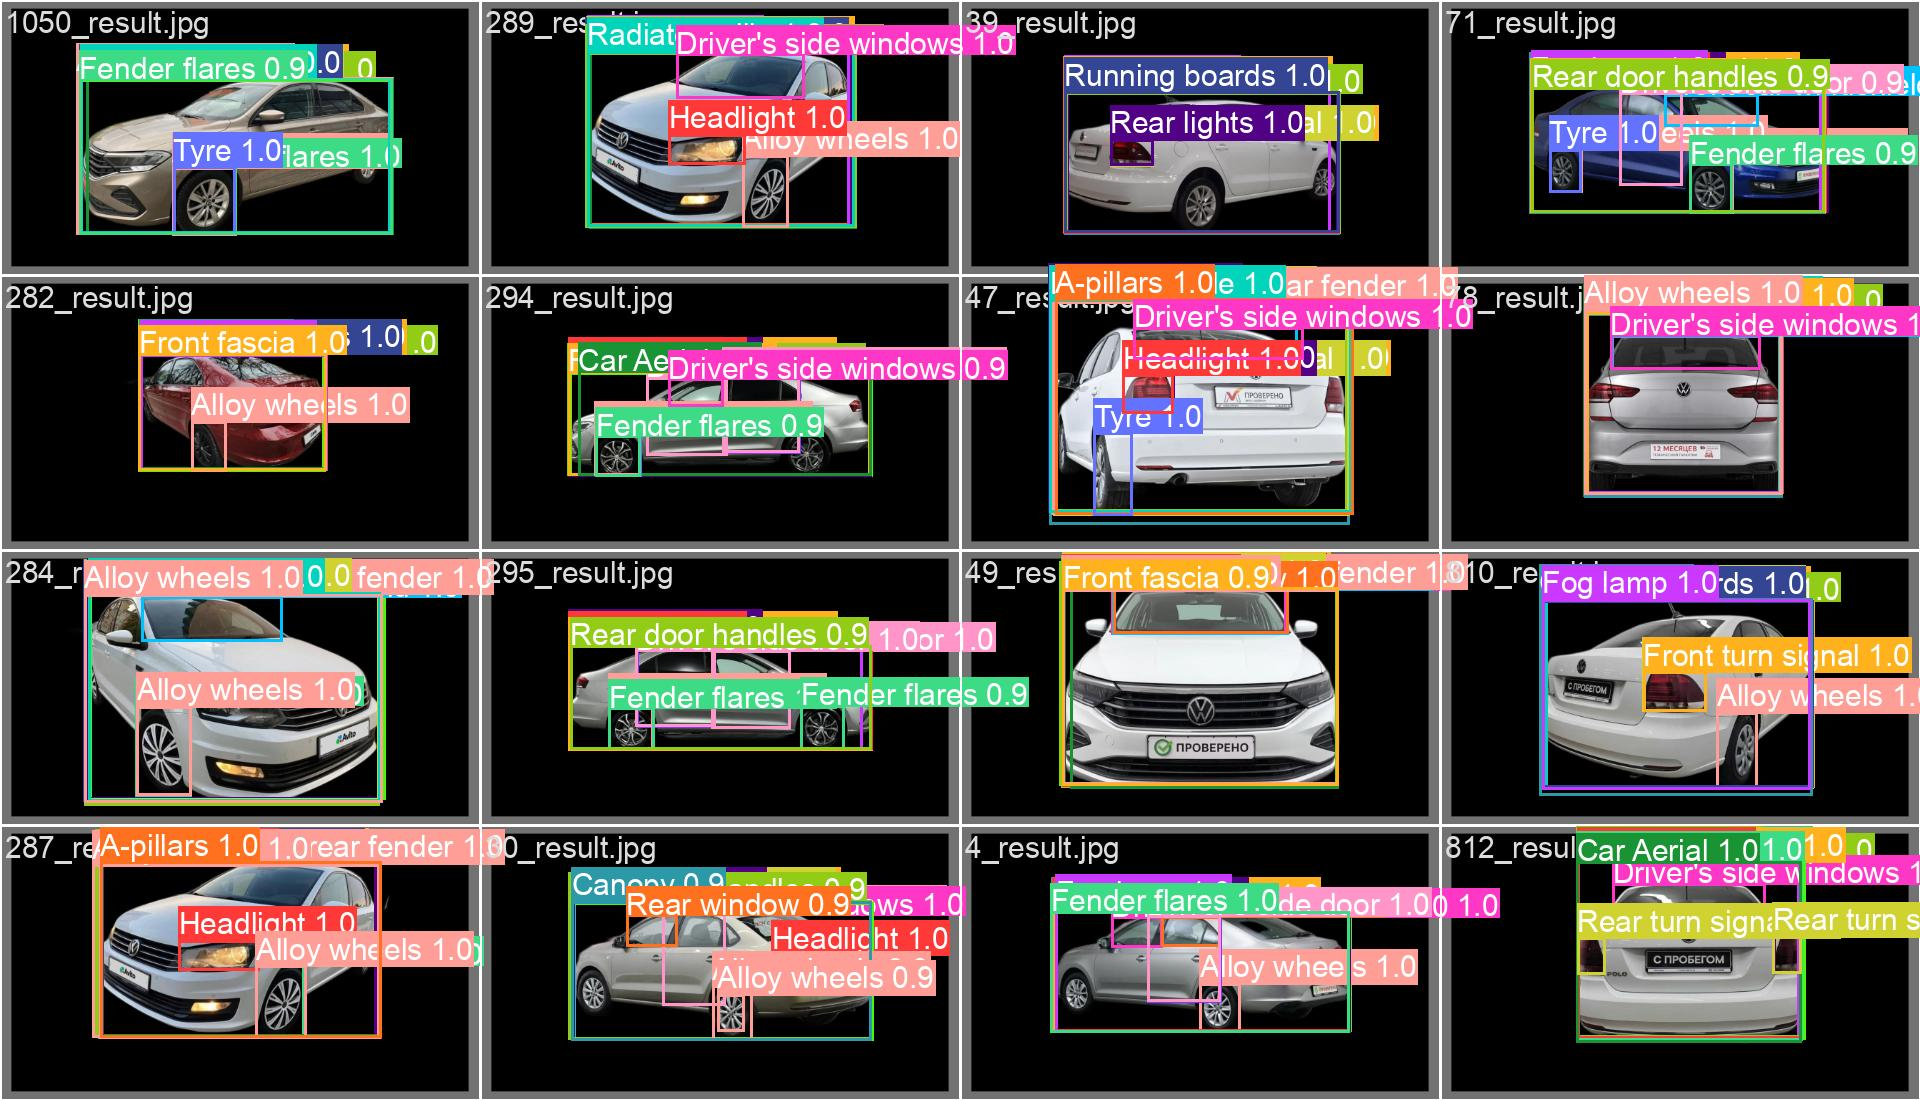

In [ ]:
%cd {HOME}

from IPython.display import Image

# Отображение изображения с предсказанными результатами (val_batch0_pred.jpg) после обучения
Image(filename=f'{HOME}/runs/detect/train2/val_batch0_pred.jpg', width=900)

# Auto Labeling result

In [ ]:
import matplotlib.pyplot as plt # Импорт библиотеки для построения графиков
import os # Импорт библиотеки для работы с операционной системой
import cv2 # Импорт библиотеки OpenCV для работы с изображениями

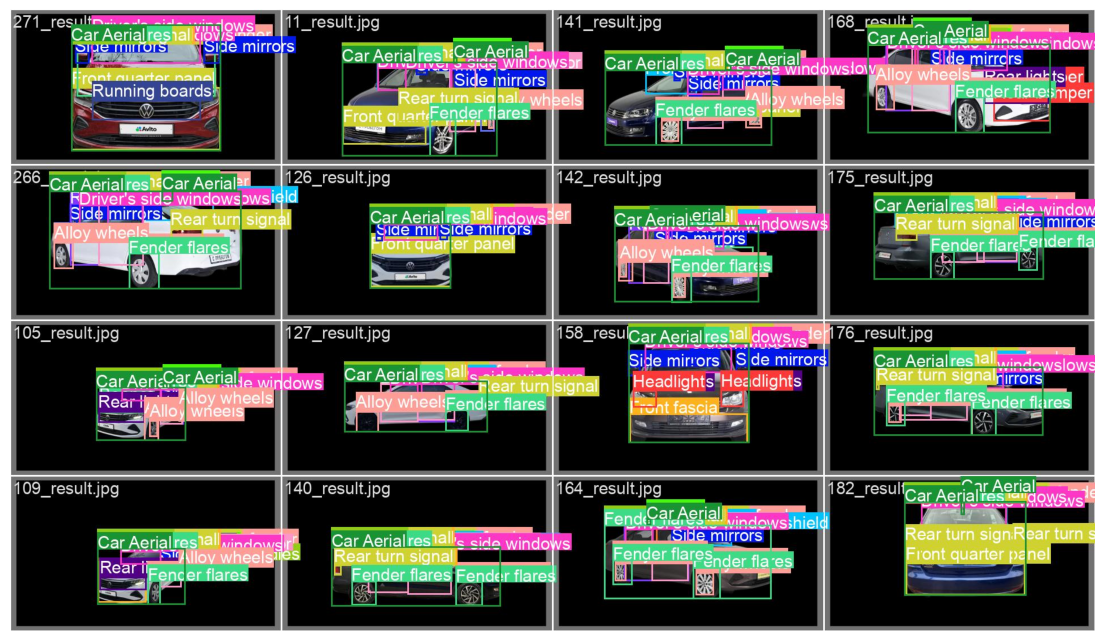

In [ ]:
image = cv2.imread('/content/runs/detect/train2/val_batch1_labels.jpg')  # Чтение изображения с метками из указанного пути
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Преобразование цветового пространства из BGR в RGB
plt.figure(figsize=(14,14))  # Создание нового графика с заданным размером
plt.imshow(image)  # Отображение изображения на графике
plt.axis('off')  # Отключение осей
plt.show() # Показ графика

# save weights

In [ ]:
from google.colab import drive # Импортировать библиотеку для работы с Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import shutil

# Копировать целую директорию 'runs' в Google Drive
shutil.copytree('/content/runs', '//content/drive/MyDrive/YOLO8m/runs')


'//content/drive/MyDrive/YOLO8m/runs'

In [ ]:
import shutil

# Копировать целую директорию 'dataset' в Google Drive
shutil.copytree('/content/dataset', '/content/drive/MyDrive/YOLO8m/datasetpolo')


'/content/drive/MyDrive/YOLO8m/datasetpolo'

**и отдельно скачивается файл YOLOv8.pt со всеми данными и весами которые были созданны ранее**





In [ ]:
# Задать путь к файлу YOLOv8.pt
yolov8_path = '/content/drive/MyDrive/YOLO8m/YOLOv8m.pt'

# Скачать файл YOLOv8.pt с Google Drive
shutil.copy('/content/drive/MyDrive/YOLO8m/YOLOv8m.pt', yolov8_path)